Data Loaded: 773869. Total data points: 34272


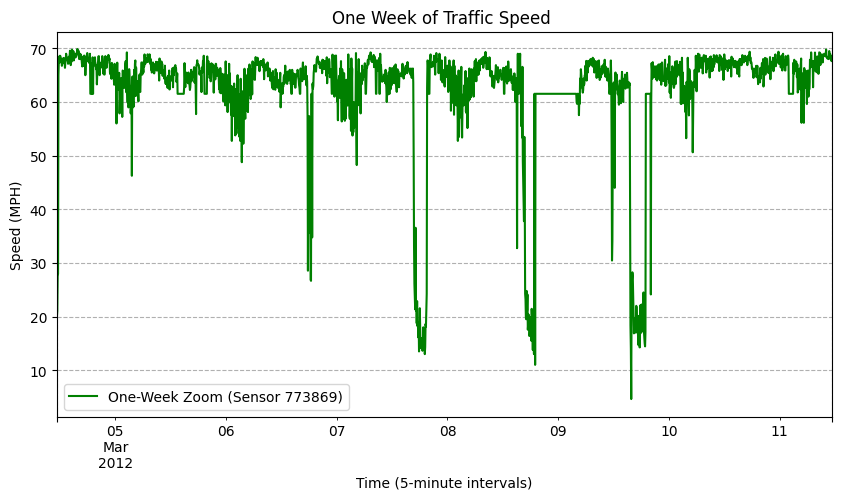

Data successfully scaled between 0 and 1.

Sequences created.
X shape (Input samples, 1-hour history, 1 feature): (34258, 12, 1)
Y shape (Output samples, 15-min forecast, 1 feature): (34258, 3, 1)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # For scaling data

# Data Loading
try:
    #  Load the data
    df_traffic = pd.read_hdf('/content/METR-LA.h5', key='df')

    # Convert the index to proper datetime objects.
    df_traffic.index = pd.to_datetime(df_traffic.index)
    df_traffic.index.freq = None

    #  Select ONE sensor (773869)
    sensor_id = df_traffic.columns[0]
    ts_data = df_traffic[sensor_id].copy()

    print(f"Data Loaded: {sensor_id}. Total data points: {len(ts_data)}")

except Exception as e:
    print(f"Error in loading or fixing index: {e}")

# Data Cleaning, Visualization, and Scaling

#Replacing the 0.0 entries (missing/bad data) with the average speed.
ts_data.replace(0, np.nan, inplace=True)
ts_data.fillna(ts_data.mean(), inplace=True)

# VISUALIZATION (understanding the data patterns)

# zoom in on just one week to clearly see the daily cycle (rush hour peaks/dips).
start_date = ts_data.index[1000]
end_date = ts_data.index[1000 + 12 * 24 * 7]

plt.figure(figsize=(10, 5))
ts_data.loc[start_date:end_date].plot(label=f"One-Week Zoom (Sensor {sensor_id})", color='g')
plt.title(f"One Week of Traffic Speed ")
plt.xlabel("Time (5-minute intervals)")
plt.ylabel("Speed (MPH)")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# Shrink the data to be between 0 and 1 for the LSTM.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data.values.reshape(-1, 1))
print("Data successfully scaled between 0 and 1.")


# Sequence Creation (The LSTM Input Format)

# The core function to create 'windows' of data.
def create_sequences(data, history_size, future_size):
    # This creates the Input (X = past data) and Output (Y = future prediction).
    X, Y = [], []
    for i in range(len(data) - history_size - future_size + 1):
        history = data[i:(i + history_size)] # Input: 1 hour of history
        future = data[i + history_size : i + history_size + future_size] # Output: Next 15 minutes

        X.append(history)
        Y.append(future)

    return np.array(X), np.array(Y)

# Hyperparameters
HISTORY_STEPS = 12   # 12 * 5-minute steps = 1 hour of past data
FUTURE_STEPS = 3    # 3 * 5-minute steps = predict the next 15 minutes

# The final training sequences
X, Y = create_sequences(scaled_data, HISTORY_STEPS, FUTURE_STEPS)

print(f"\nSequences created.")
print(f"X shape (Input samples, 1-hour history, 1 feature): {X.shape}")
print(f"Y shape (Output samples, 15-min forecast, 1 feature): {Y.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Model Building

N_TIMESTEPS = X.shape[1]
N_FEATURES = X.shape[2]
N_OUTPUT_STEPS = Y.shape[1]

# Initialize the Sequential Model
model = Sequential()

# Adding the first LSTM layer.
model.add(LSTM(units=50,
               activation='relu',
               return_sequences=True,
               input_shape=(N_TIMESTEPS, N_FEATURES)))

# Adding a second LSTM layer.
model.add(LSTM(units=50, activation='relu'))

# Adding the final output layer (Dense layer).
model.add(Dense(units=N_OUTPUT_STEPS))

# Compiling the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

#model summary
print("LSTM Model Architecture Summary ")
model.summary()

LSTM Model Architecture Summary 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,753 (120.13 KB)

 Trainable params: 30,753 (120.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# Training Setup

# SPLIT THE DATA
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(f"Total samples: {len(X)}")
print(f"Training samples (80%): {len(X_train)}")
print(f"Testing samples (20%): {len(X_test)}")


# TRAIN THE MODEL
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, Y_test),
                    verbose=1)

print("\nModel training complete!")

Total samples: 34258
Training samples (80%): 27406
Testing samples (20%): 6852
Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0899 - mae: 0.1538 - val_loss: 0.0093 - val_mae: 0.0449
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0078 - mae: 0.0449 - val_loss: 0.0076 - val_mae: 0.0519
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0062 - mae: 0.0419 - val_loss: 0.0061 - val_mae: 0.0366
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0054 - mae: 0.0377 - val_loss: 0.0059 - val_mae: 0.0365
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0059 - mae: 0.0382 - val_loss: 0.0058 - val_mae: 0.0366
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0055 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0363
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0055 - mae: 0.0376 - val_loss: 0.0064 - val_mae: 0.0411
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0057 - mae: 0.0374 - val_loss: 0

 Final Model Evaluation on Test Data 
Test MAE (in scaled 0-1 range): 0.0361

 Final Results in MPH 
FINAL MAE (Mean Absolute Error): 2.44 MPH
FINAL RMSE (Root Mean Square Error): 5.14 MPH


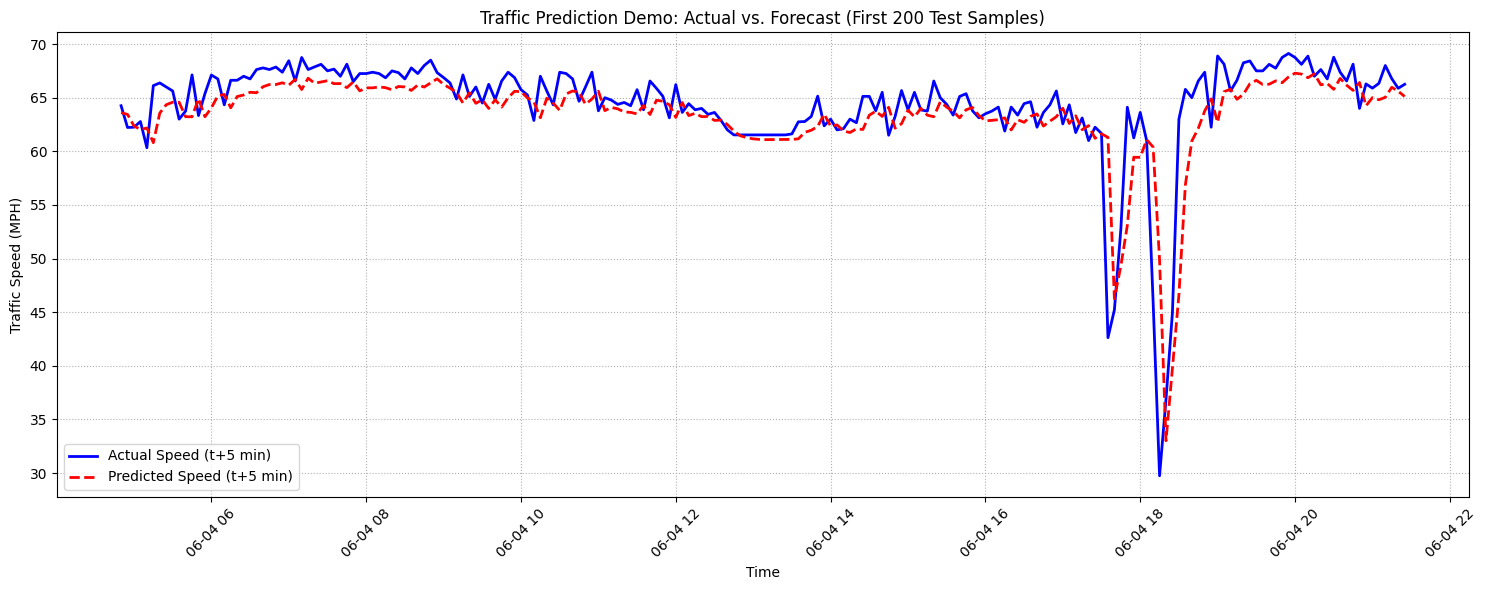

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Evaluation

# Evaluating the model on the unseen test data
print(" Final Model Evaluation on Test Data ")
# 'verbose=0' means no training output, just the result
loss, mae_scaled = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MAE (in scaled 0-1 range): {mae_scaled:.4f}")

# Generate predictions for the test set
# This gives predictions in the scaled (0 to 1) range
scaled_predictions = model.predict(X_test, verbose=0)


# UN-SCALE THE VALUES

true_values_flat = Y_test.flatten().reshape(-1, 1)
true_values = scaler.inverse_transform(true_values_flat)

# Un-scale Predictions
predicted_values_flat = scaled_predictions.flatten().reshape(-1, 1)
predicted_values = scaler.inverse_transform(predicted_values_flat)

# Calculate Final Metrics in MPH
final_mae_mph = mean_absolute_error(true_values, predicted_values)
final_rmse_mph = np.sqrt(mean_squared_error(true_values, predicted_values))

print(f"\n Final Results in MPH ")
print(f"FINAL MAE (Mean Absolute Error): {final_mae_mph:.2f} MPH")
print(f"FINAL RMSE (Root Mean Square Error): {final_rmse_mph:.2f} MPH")

#FINAL VISUAL DEMO: Actual vs. Predicted

# Make a graph to compare the real speed to the predicted speed.
plt.figure(figsize=(15, 6))

# Get the time index for the plotting window
plot_start_index = len(X_train) + HISTORY_STEPS
time_index_plot = ts_data.index[plot_start_index : plot_start_index + len(X_test)]

# Reshape the unscaled results back to (samples, FUTURE_STEPS) for plotting
predicted_values_plot = predicted_values.reshape(len(X_test), FUTURE_STEPS)
true_values_plot = true_values.reshape(len(X_test), FUTURE_STEPS)

# Plot the real speed for the next 5 minutes
plt.plot(time_index_plot[:200], true_values_plot[:200, 0],
         label='Actual Speed (t+5 min)', color='blue', linewidth=2)
# Plot the model's predicted speed
plt.plot(time_index_plot[:200], predicted_values_plot[:200, 0],
         label='Predicted Speed (t+5 min)', color='red', linestyle='--', linewidth=2)

plt.title("Traffic Prediction Demo: Actual vs. Forecast (First 200 Test Samples)")
plt.xlabel("Time")
plt.ylabel("Traffic Speed (MPH)")
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()